# Graph Coloring - Parallel and Distributed Computing Project

## Problem Description
**Graph Coloring** is a classic NP-hard problem where we assign colors to vertices of a graph such that no two adjacent vertices share the same color. The goal is to use the minimum number of colors (chromatic number).

---

## Algorithm: Greedy Coloring with Iterative Conflict Resolution

### Sequential Algorithm
The sequential greedy algorithm processes vertices one by one:
1. For each vertex `v`, find the set of colors used by its neighbors
2. Assign `v` the smallest color not in that set
3. Move to the next vertex

**Time Complexity:** O(V + E) where V = vertices, E = edges

### Parallel Algorithm (Speculative Coloring)
Since the sequential algorithm has inherent dependencies (each vertex depends on its neighbors), we use a **speculative approach**:

1. **Phase 1 - Tentative Coloring:** All threads color their assigned vertices in parallel using the greedy rule
2. **Phase 2 - Conflict Detection:** Check for conflicts (adjacent vertices with same color). For conflicts, the vertex with the smaller ID keeps its color; the other is marked for re-coloring
3. **Repeat** until no conflicts remain

This approach is based on the **Jones-Plassmann** and **Luby's parallel graph coloring** algorithms.

---

## Implementations Overview

| Implementation | Parallelism Type | Technology |
|----------------|------------------|------------|
| Java Sequential | None (baseline) | Single thread |
| Java Parallel | Shared Memory | Java Threads + CyclicBarrier |
| MPI (C++) | Distributed Memory | OpenMPI |
| CUDA | GPU Massively Parallel | CUDA Kernels |

---

## Synchronization Mechanisms

### 1. Java Parallel Implementation

#### CyclicBarrier
```java
CyclicBarrier barrier = new CyclicBarrier(T); // T = number of threads
```
- **Purpose:** Ensures all threads complete Phase 1 (coloring) before any thread starts Phase 2 (conflict detection)
- **How it works:** Each thread calls `barrier.await()` and blocks until all T threads have reached that point
- **Why needed:** Without synchronization, a thread might check conflicts while another is still coloring, leading to race conditions

#### ConcurrentHashMap.newKeySet()
```java
Set<Integer> todo = ConcurrentHashMap.newKeySet();
Set<Integer> nextTodo = ConcurrentHashMap.newKeySet();
```
- **Purpose:** Thread-safe sets for tracking which nodes need (re)coloring
- **How it works:** Multiple threads can safely add conflicting nodes to `nextTodo` simultaneously
- **Why needed:** A regular `HashSet` would corrupt data with concurrent writes

#### Thread.join()
```java
for(Thread t : threads) t.join();
```
- **Purpose:** Main thread waits for all worker threads to complete before swapping todo lists

### 2. MPI Distributed Implementation (C++)

#### MPI_Bcast (Broadcast)
```cpp
MPI_Bcast(&n, 1, MPI_INT, 0, MPI_COMM_WORLD);
MPI_Bcast(row_ptr.data(), n + 1, MPI_INT, 0, MPI_COMM_WORLD);
```
- **Purpose:** Root process (rank 0) broadcasts the graph structure (CSR format) to all processes
- **Synchronization:** Blocking - all processes wait until broadcast completes

#### MPI_Allgatherv
```cpp
MPI_Allgatherv(my_colors.data(), my_count, MPI_INT,
               all_colors.data(), recvcounts.data(), displs.data(), 
               MPI_INT, MPI_COMM_WORLD);
```
- **Purpose:** After local coloring, each process shares its colors with all others
- **Synchronization:** Collective operation - all processes must participate
- **Why Allgatherv:** Handles uneven partitions when n is not divisible by process count

#### MPI_Allreduce
```cpp
MPI_Allreduce(&local_conflicts, &global_conflicts, 1, MPI_INT, MPI_SUM, MPI_COMM_WORLD);
```
- **Purpose:** Sum all local conflict counts to determine if ANY process still has conflicts
- **Synchronization:** Blocking collective - ensures global consensus on termination

#### MPI_Barrier
```cpp
MPI_Barrier(MPI_COMM_WORLD);
double start_time = MPI_Wtime();
```
- **Purpose:** Synchronize all processes before timing and after completion
- **Why needed:** Ensures accurate timing by starting all processes simultaneously

### 3. CUDA Implementation

#### cudaDeviceSynchronize()
```cpp
color_kernel<<<grid, block>>>(...);
cudaDeviceSynchronize();
conflict_kernel<<<grid, block>>>(...);
```
- **Purpose:** Host waits for GPU kernel to complete before launching next kernel
- **Why needed:** Ensures all threads finish coloring before conflict detection begins

#### Implicit Thread Synchronization
- Threads within a block can use `__syncthreads()` for intra-block sync
- Our implementation uses kernel boundaries for global synchronization

---

## Performance Analysis

### Expected Behavior
- **Sequential:** Predictable O(V+E) performance, no overhead
- **Java Parallel:** Speedup depends on graph structure; dense graphs may have more conflicts requiring more iterations
- **MPI:** Communication overhead significant for small graphs; shines with large graphs across nodes
- **CUDA:** Memory transfer overhead; best for very large graphs where massive parallelism compensates


In [ ]:
%%writefile coloring.cu
#include <iostream>
#include <fstream>
#include <vector>
#include <cuda_runtime.h>
#include <algorithm>

using namespace std;

// --- KERNELS ---
__global__ void color_kernel(int n, int* row_off, int* adj, int* colors, int* mask) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    if (tid < n && mask[tid]) {
        int start = row_off[tid];
        int end = row_off[tid+1];
        int forbidden[128] = {0}; // Simple mask for colors 0-127

        for (int i=start; i<end; i++) {
            int n_color = colors[adj[i]];
            if (n_color >= 0 && n_color < 128) forbidden[n_color] = 1;
        }
        int c = 0;
        while (c < 128 && forbidden[c]) c++;
        colors[tid] = c;
    }
}

__global__ void conflict_kernel(int n, int* row_off, int* adj, int* colors, int* mask, int* flag) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    if (tid < n && mask[tid]) {
        mask[tid] = 0; // Assume success
        int my_c = colors[tid];
        int start = row_off[tid];
        int end = row_off[tid+1];

        for (int i=start; i<end; i++) {
            int neighbor = adj[i];
            if (colors[neighbor] == my_c && tid < neighbor) {
                mask[tid] = 1; // I must retry
                *flag = 1;
            }
        }
    }
}

// --- MAIN ---
int main() {
    // 1. Read Graph from File
    ifstream file("graph.txt");
    int N;
    file >> N;

    vector<vector<int>> adjList(N);
    int u, v;
    while (file >> u >> v) {
        adjList[u].push_back(v);
        adjList[v].push_back(u);
    }

    // Convert to CSR
    vector<int> h_row_off = {0};
    vector<int> h_adj;
    for (const auto& neighbors : adjList) {
        for (int n : neighbors) h_adj.push_back(n);
        h_row_off.push_back(h_adj.size());
    }

    // 2. Prepare GPU
    int *d_row, *d_adj, *d_colors, *d_mask, *d_flag;
    cudaMalloc(&d_row, h_row_off.size()*4);
    cudaMalloc(&d_adj, h_adj.size()*4);
    cudaMalloc(&d_colors, N*4);
    cudaMalloc(&d_mask, N*4);
    cudaMalloc(&d_flag, 4);

    cudaMemcpy(d_row, h_row_off.data(), h_row_off.size()*4, cudaMemcpyHostToDevice);
    cudaMemcpy(d_adj, h_adj.data(), h_adj.size()*4, cudaMemcpyHostToDevice);

    vector<int> h_mask(N, 1); // All nodes need coloring
    vector<int> h_colors(N, -1);
    cudaMemcpy(d_mask, h_mask.data(), N*4, cudaMemcpyHostToDevice);
    cudaMemcpy(d_colors, h_colors.data(), N*4, cudaMemcpyHostToDevice);

    // 3. Solve
    int h_flag = 1;
    cudaEvent_t start, stop;
    cudaEventCreate(&start); cudaEventCreate(&stop);
    cudaEventRecord(start);

    while(h_flag) {
        h_flag = 0;
        cudaMemcpy(d_flag, &h_flag, 4, cudaMemcpyHostToDevice);

        int block = 256;
        int grid = (N + block - 1) / block;

        color_kernel<<<grid, block>>>(N, d_row, d_adj, d_colors, d_mask);
        cudaDeviceSynchronize();
        conflict_kernel<<<grid, block>>>(N, d_row, d_adj, d_colors, d_mask, d_flag);
        cudaDeviceSynchronize();

        cudaMemcpy(&h_flag, d_flag, 4, cudaMemcpyDeviceToHost);
    }

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    float ms = 0;
    cudaEventElapsedTime(&ms, start, stop);

    cout << (int)ms << endl; // Output integer ms for script
    return 0;
}

Writing coloring.cu


In [ ]:
# @title 1. Install Java & Generate Test Graph
import os
import random

# 1. Install Java (OpenJDK 11)
!apt-get install -y openjdk-11-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

# 2. Generate graph.txt
# Format:
# Number_of_Nodes
# NodeA NodeB
# NodeC NodeD ...
def generate_graph_file(filename, nodes, density):
    print(f"Generating graph with {nodes} nodes...")
    edges = []
    # Ensure graph is somewhat connected
    for i in range(nodes - 1):
        edges.append((i, i + 1))

    # Add random edges
    max_extra = int(nodes * density)
    for _ in range(max_extra):
        u = random.randint(0, nodes - 1)
        v = random.randint(0, nodes - 1)
        if u != v:
            edges.append((u, v))

    with open(filename, 'w') as f:
        f.write(f"{nodes}\n")
        for u, v in edges:
            f.write(f"{u} {v}\n")
    print(f"Graph saved to {filename} with {len(edges)} edges.")

# Generate a graph with 10,000 nodes
generate_graph_file("graph.txt", 10000, 10.0)

Generating graph with 10000 nodes...
Graph saved to graph.txt with 109989 edges.


In [ ]:
%%writefile Main.java
import java.io.*;
import java.util.*;
import java.util.concurrent.*;

// --- CLASS: NODE ---
class Node {
    int label;
    int color = -1;
    List<Integer> neighbours = new ArrayList<>();
    public Node(int label) { this.label = label; }
}

// --- CLASS: GRAPH ---
class Graph {
    List<Node> nodes = new ArrayList<>();
    public Graph(String filename) throws IOException {
        BufferedReader br = new BufferedReader(new FileReader(filename));
        int n = Integer.parseInt(br.readLine());
        for(int i=0; i<n; i++) nodes.add(new Node(i));

        String line;
        while((line = br.readLine()) != null) {
            String[] parts = line.split(" ");
            int u = Integer.parseInt(parts[0]);
            int v = Integer.parseInt(parts[1]);
            nodes.get(u).neighbours.add(v);
            nodes.get(v).neighbours.add(u);
        }
        br.close();
    }
    public boolean check() {
        for(Node node : nodes) {
            for(int neighborIdx : node.neighbours) {
                if(node.color != -1 && node.color == nodes.get(neighborIdx).color) return false;
            }
        }
        return true;
    }
}

// --- THREAD WORKER ---
class ColoringThread implements Runnable {
    Graph G; int start, end; CyclicBarrier barrier;
    Set<Integer> todo, nextTodo;

    public ColoringThread(Graph G, int s, int e, CyclicBarrier b, Set<Integer> t, Set<Integer> n) {
        this.G = G; this.start = s; this.end = e; this.barrier = b; this.todo = t; this.nextTodo = n;
    }

    public void run() {
        // Phase 1: Color
        // Only process nodes that are in the 'todo' list (nodes that failed previous round)
        for(int i=start; i<end; i++) {
            if(todo.contains(i)) {
                Node node = G.nodes.get(i);
                // 1. See what neighbors have right now
                Set<Integer> used = new HashSet<>();
                for(int n : node.neighbours) used.add(G.nodes.get(n).color);
                int c = 0;
                //pick smallest availabe
                while(used.contains(c)) c++;
                node.color = c;
            }
        }
        // WAIT! Ensure all threads finished coloring before we check for errors.
        try { barrier.await(); } catch(Exception e){}

        // Phase 2: Detect Conflicts
        for(int i=start; i<end; i++) {
            if(todo.contains(i)) {
                Node u = G.nodes.get(i);
                for(int vIdx : u.neighbours) {
                    if(u.color == G.nodes.get(vIdx).color && i < vIdx) {
                        nextTodo.add(i); // I will change color next time
                    }
                }
            }
        }
        // WAIT! Ensure everyone finished checking before Main swaps the lists.
        try { barrier.await(); } catch(Exception e){}
    }
}

// --- MAIN CLASS ---
public class Main {
    public static void main(String[] args) throws Exception {
        String mode = args.length > 0 ? args[0] : "seq";
        Graph graph = new Graph("graph.txt");

        long start = System.nanoTime();

        if (mode.equals("seq")) {
            solveSequential(graph);
        } else {
            solveParallel(graph);
        }

        long duration = (System.nanoTime() - start) / 1000000;
        System.out.println(duration); // Output only the number for the script to parse

        if(!graph.check()) System.err.println("Error: Invalid Coloring!");
    }

    static void solveSequential(Graph g) {
        for(Node node : g.nodes) {
            Set<Integer> used = new HashSet<>();
            for(int n : node.neighbours) used.add(g.nodes.get(n).color);
            int c = 0;
            while(used.contains(c)) c++;
            node.color = c;
        }
    }

    static void solveParallel(Graph g) throws Exception {
        int T = 4; // Threads
        //In Phase 2, multiple threads (Thread 1, Thread 2...)
        //might find nodes that need re-coloring. They all try to add these nodes
        //to the nextTodo set at the same time.

//A regular HashSet would crash or corrupt data if two threads wrote to it simultaneously.

//ConcurrentHashMap.newKeySet() is a thread-safe set that handles this perfectly.
        Set<Integer> todo = ConcurrentHashMap.newKeySet();
        // 1. Initial Setup: Everyone needs coloring at the start
        for(int i=0; i<g.nodes.size(); i++) todo.add(i);

        CyclicBarrier barrier = new CyclicBarrier(T);

        while(!todo.isEmpty()) {
            Set<Integer> nextTodo = ConcurrentHashMap.newKeySet();
            List<Thread> threads = new ArrayList<>();
            //divide graph into chunks
            int chunk = g.nodes.size() / T;

            for(int i=0; i<T; i++) {
              // Calculate start and end index for this thread
                int s = i * chunk;
                int e = (i==T-1) ? g.nodes.size() : (i+1)*chunk;
                //create worker
                threads.add(new Thread(new ColoringThread(g, s, e, barrier, todo, nextTodo)));
            }
            for(Thread t : threads) t.start();
            for(Thread t : threads) t.join();
            todo = nextTodo;
        }
    }
}

Writing Main.java


In [ ]:
%%writefile coloring_mpi.cpp
/*
 * MPI Distributed Graph Coloring in C++
 * Uses speculative coloring with iterative conflict resolution.
 * 
 * Compile: mpic++ -O3 -o coloring_mpi coloring_mpi.cpp
 * Run:     mpirun -np 4 ./coloring_mpi
 */

#include <mpi.h>
#include <iostream>
#include <fstream>
#include <vector>
#include <set>
#include <cstring>

using namespace std;

int main(int argc, char** argv) {
    MPI_Init(&argc, &argv);
    
    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);
    
    int n = 0;
    vector<int> row_ptr;    // CSR row pointers
    vector<int> col_idx;    // CSR column indices
    
    // --- 1. Root reads graph and converts to CSR format ---
    if (rank == 0) {
        ifstream file("graph.txt");
        file >> n;
        
        vector<vector<int>> adj(n);
        int u, v;
        while (file >> u >> v) {
            adj[u].push_back(v);
            adj[v].push_back(u);
        }
        file.close();
        
        // Convert to CSR
        row_ptr.resize(n + 1);
        row_ptr[0] = 0;
        for (int i = 0; i < n; i++) {
            for (int nb : adj[i]) {
                col_idx.push_back(nb);
            }
            row_ptr[i + 1] = col_idx.size();
        }
    }
    
    // --- 2. Broadcast graph structure ---
    MPI_Bcast(&n, 1, MPI_INT, 0, MPI_COMM_WORLD);
    
    int num_edges = 0;
    if (rank == 0) {
        num_edges = col_idx.size();
    }
    MPI_Bcast(&num_edges, 1, MPI_INT, 0, MPI_COMM_WORLD);
    
    // Allocate on non-root processes
    if (rank != 0) {
        row_ptr.resize(n + 1);
        col_idx.resize(num_edges);
    }
    
    // Broadcast CSR arrays
    MPI_Bcast(row_ptr.data(), n + 1, MPI_INT, 0, MPI_COMM_WORLD);
    MPI_Bcast(col_idx.data(), num_edges, MPI_INT, 0, MPI_COMM_WORLD);
    
    // --- 3. Partition vertices among processes ---
    int chunk = n / size;
    int start_v = rank * chunk;
    int end_v = (rank == size - 1) ? n : (rank + 1) * chunk;
    int my_count = end_v - start_v;
    
    // Colors array: -1 = uncolored
    vector<int> colors(n, -1);
    
    // Track which of my vertices need coloring (using bitmask for efficiency)
    vector<bool> todo(n, false);
    for (int v = start_v; v < end_v; v++) {
        todo[v] = true;
    }
    
    // Prepare for MPI_Allgatherv
    vector<int> recvcounts(size);
    vector<int> displs(size);
    for (int i = 0; i < size; i++) {
        displs[i] = i * chunk;
        recvcounts[i] = (i == size - 1) ? (n - chunk * (size - 1)) : chunk;
    }
    
    // --- 4. Start timing ---
    MPI_Barrier(MPI_COMM_WORLD);
    double start_time = MPI_Wtime();
    
    int global_conflicts = 1;
    int max_iterations = 1000;
    
    for (int iter = 0; iter < max_iterations && global_conflicts > 0; iter++) {
        
        // --- Phase 1: Tentative Coloring ---
        for (int v = start_v; v < end_v; v++) {
            if (!todo[v]) continue;
            
            // Find forbidden colors from neighbors
            set<int> forbidden;
            for (int j = row_ptr[v]; j < row_ptr[v + 1]; j++) {
                int neighbor = col_idx[j];
                if (colors[neighbor] >= 0) {
                    forbidden.insert(colors[neighbor]);
                }
            }
            
            // Find smallest available color
            int c = 0;
            while (forbidden.count(c)) c++;
            colors[v] = c;
        }
        
        // --- Synchronize colors across all processes using MPI_Allgatherv ---
        vector<int> my_colors(colors.begin() + start_v, colors.begin() + end_v);
        vector<int> all_colors(n);
        
        MPI_Allgatherv(my_colors.data(), my_count, MPI_INT,
                       all_colors.data(), recvcounts.data(), displs.data(), 
                       MPI_INT, MPI_COMM_WORLD);
        
        colors = all_colors;
        
        // --- Phase 2: Conflict Detection ---
        vector<bool> next_todo(n, false);
        int local_conflicts = 0;
        
        for (int v = start_v; v < end_v; v++) {
            if (!todo[v]) continue;
            
            int my_color = colors[v];
            for (int j = row_ptr[v]; j < row_ptr[v + 1]; j++) {
                int neighbor = col_idx[j];
                // Conflict: same color and I have higher ID -> I must retry
                if (colors[neighbor] == my_color && v > neighbor) {
                    next_todo[v] = true;
                    local_conflicts++;
                    break;
                }
            }
        }
        
        todo = next_todo;
        
        // --- Check global termination using MPI_Allreduce ---
        MPI_Allreduce(&local_conflicts, &global_conflicts, 1, MPI_INT, MPI_SUM, MPI_COMM_WORLD);
    }
    
    // --- 5. End timing ---
    MPI_Barrier(MPI_COMM_WORLD);
    double end_time = MPI_Wtime();
    
    // --- 6. Verify and output (root only) ---
    if (rank == 0) {
        // Verify coloring
        bool valid = true;
        for (int v = 0; v < n && valid; v++) {
            for (int j = row_ptr[v]; j < row_ptr[v + 1]; j++) {
                int neighbor = col_idx[j];
                if (colors[v] == colors[neighbor]) {
                    valid = false;
                    break;
                }
            }
        }
        
        int elapsed_ms = (int)((end_time - start_time) * 1000);
        cout << elapsed_ms << endl;  // Output only time for parsing
        
        if (!valid) {
            cerr << "Error: Invalid coloring!" << endl;
        }
    }
    
    MPI_Finalize();
    return 0;
}


--- 1. Compiling Java ---
--- 2. Compiling CUDA ---
--- 3. Running Algorithms ---
Running Java Sequential...
Running Java Parallel (4 Threads)...
Running CUDA (GPU)...

--- Results (Time in ms) ---
Java Sequential: 52 ms
Java Parallel: 85 ms
CUDA (GPU): 42 ms


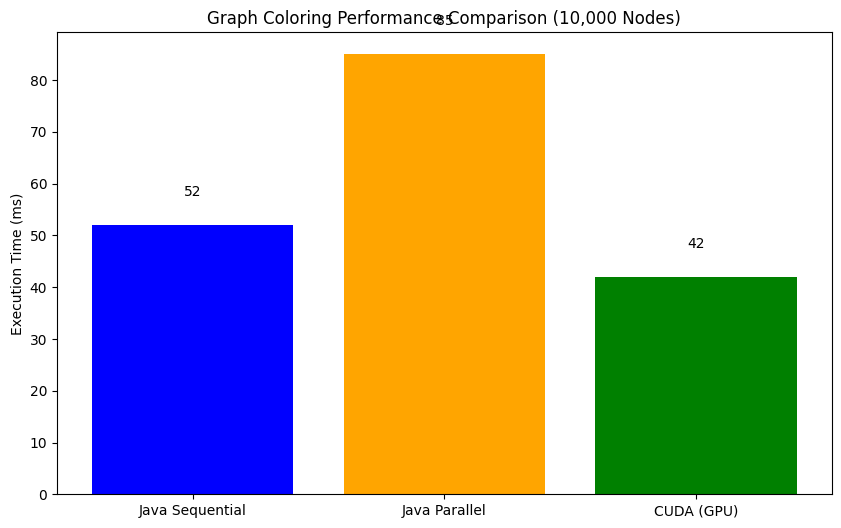

In [ ]:
# @title 5. Compile, Run, and Compare Parallel Implementations
import subprocess
import matplotlib.pyplot as plt

def run_command(cmd, timeout=120):
    """Runs a shell command and returns the stdout"""
    try:
        process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        out, err = process.communicate(timeout=timeout)
        if process.returncode != 0:
            print(f"Error running {cmd}:\n{err.decode()}")
            return None
        return out.decode().strip()
    except subprocess.TimeoutExpired:
        process.kill()
        print(f"Timeout running {cmd}")
        return None

# --- 1. Install MPI ---
print("--- 1. Installing MPI ---")
run_command("apt-get install -y openmpi-bin libopenmpi-dev -qq > /dev/null 2>&1")

print("--- 2. Compiling Java ---")
run_command("javac Main.java")

print("--- 3. Compiling CUDA ---")
run_command("nvcc -o coloring coloring.cu")

print("--- 4. Compiling MPI (C++) ---")
run_command("mpic++ -O3 -o coloring_mpi coloring_mpi.cpp")

print("--- 5. Running All Algorithms ---")

# Run Java Sequential (baseline for speedup calculation)
print("Running Java Sequential (baseline)...")
out_seq = run_command("java Main seq")
sequential_time = int(out_seq.splitlines()[-1]) if out_seq else None

# Results dictionary for the 3 parallel implementations
results = {}

# 1. Java Parallel (Shared Memory - Threads)
print("Running Java Parallel (4 Threads)...")
out_par = run_command("java Main par")
if out_par:
    results['Java Parallel\n(Threads)'] = int(out_par.splitlines()[-1])

# 2. MPI C++ (Distributed Memory)
print("Running MPI C++ (4 Processes)...")
out_mpi = run_command("mpirun --allow-run-as-root --oversubscribe -np 4 ./coloring_mpi")
if out_mpi:
    results['MPI C++\n(Distributed)'] = int(out_mpi.splitlines()[-1])

# 3. CUDA (GPU)
print("Running CUDA (GPU)...")
out_cuda = run_command("./coloring")
if out_cuda:
    results['CUDA\n(GPU)'] = int(out_cuda.splitlines()[-1])

# --- 6. Display Results ---
print("\n" + "="*60)
print("PERFORMANCE COMPARISON: Parallel vs Distributed vs GPU")
print("="*60)
print(f"\nBaseline (Sequential): {sequential_time} ms\n")
for k, v in results.items():
    label = k.replace(chr(10), ' ')
    speedup = sequential_time / v if (sequential_time and v > 0) else 0
    print(f"{label}: {v} ms (speedup: {speedup:.2f}x)")

# --- 7. Plotting ---
if results:
    names = list(results.keys())
    times = list(results.values())
    bar_colors = ['#e74c3c', '#9b59b6', '#2ecc71']  # Red, Purple, Green

    plt.figure(figsize=(10, 7))
    plt.style.use('seaborn-v0_8-whitegrid')
    
    bars = plt.bar(names, times, color=bar_colors[:len(names)], edgecolor='black', linewidth=1.5)

    plt.ylabel('Execution Time (ms)', fontsize=13)
    plt.xlabel('Implementation Type', fontsize=13)
    plt.title('Graph Coloring: Parallel vs Distributed vs GPU\n(10,000 Nodes, ~110,000 Edges)', 
              fontsize=14, fontweight='bold')

    # Add values on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + max(times)*0.02, 
                 f'{int(yval)} ms', ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Add sequential baseline line
    if sequential_time:
        plt.axhline(y=sequential_time, color='blue', linestyle='--', linewidth=2, label=f'Sequential Baseline ({sequential_time} ms)')
        plt.legend(loc='upper right', fontsize=11)

    plt.ylim(0, max(max(times), sequential_time if sequential_time else 0) * 1.2)
    plt.tight_layout()
    
    # Save the chart as PNG for documentation
    plt.savefig('performance_chart.png', dpi=300, bbox_inches='tight')
    print("\n[Chart saved as 'performance_chart.png']")
    
    plt.show()
    
    # Speedup summary
    print("\n" + "="*60)
    print("SPEEDUP SUMMARY (vs Sequential Baseline)")
    print("="*60)
    for k, v in results.items():
        if sequential_time and v > 0:
            speedup = sequential_time / v
            label = k.replace(chr(10), ' ')
            bar = "█" * int(speedup * 10)
            print(f"{label}: {speedup:.2f}x {bar}")
else:
    print("No results to plot.")